In [2]:
import pandas as pd
import matplotlib

In [3]:
data = pd.read_csv('data/train_data/train_task_3_4.csv')
print(len(data))
data.head()

1382727


,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue
0,898,2111,280203,1,2,2
1,767,3062,55638,1,3,3
2,165,1156,386475,1,2,2
3,490,1653,997498,1,4,4
4,298,3912,578636,1,3,3


In [4]:
# calc percent of correct for each question
correct_ratio=[]
for k,df in data.groupby('QuestionId'):
    correct_ratio.append((k, len(df), df['IsCorrect'].mean(), df['IsCorrect'].sem()))
for k,cnt,ratio,stdm in correct_ratio[:5]:
    print(k,cnt,ratio,stdm)

0 2812 0.44345661450924606 0.00937010933612387
1 14 0.5714285714285714 0.13725270326150324
2 2313 0.3852140077821012 0.01012089927190456
3 2672 0.8087574850299402 0.007609645680958906
4 1704 0.4014084507042254 0.011878216105763999


In [6]:
#TODO


In [7]:
# load evaluators' score on "validation" set
eval_validation = pd.read_csv('data/test_data/quality_response_remapped_public.csv')
print(len(eval_validation))
eval_validation.head()

25


,Unnamed: 0.1,Unnamed: 0,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS
0,0,0,909,318,2,2,2,1.0,2
1,16,16,285,609,2,2,2,2.0,2
2,48,48,132,271,1,2,2,2.0,1
3,38,38,704,127,2,2,1,2.0,2
4,33,33,16,586,1,1,2,2.0,2


In [8]:
# take the average of 5 evaulators` scores
eval_validation['score'] = eval_validation.filter(regex='^T', axis = 1).mean(axis=1)
eval_validation

,Unnamed: 0.1,Unnamed: 0,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS,score
0,0,0,909,318,2,2,2,1.0,2,1.8
1,16,16,285,609,2,2,2,2.0,2,2.0
2,48,48,132,271,1,2,2,2.0,1,1.6
3,38,38,704,127,2,2,1,2.0,2,1.8
4,33,33,16,586,1,1,2,2.0,2,1.6
5,17,17,56,865,2,1,2,2.0,2,1.8
6,27,27,233,478,1,1,1,1.0,2,1.2
7,41,41,877,620,2,2,2,2.0,2,2.0
8,5,5,246,733,1,1,1,2.0,1,1.2
9,35,35,668,741,1,1,1,1.0,1,1.0


<Axes: >

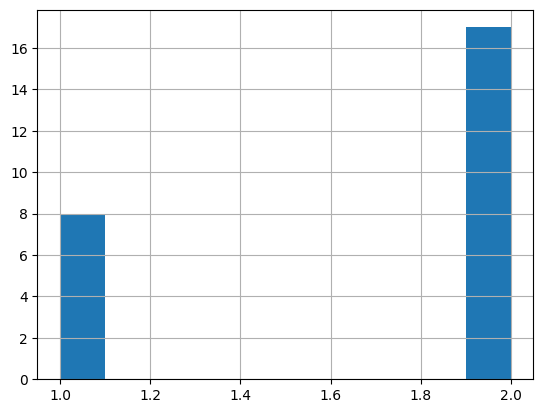

In [28]:
# decide preference
import numpy as np
def calc_preference(scores):
    preference = np.ones(len(scores), dtype=int)

    idx_two = scores > 1.5
    preference[idx_two] = 2
    
    return list(preference)

eval_validation['preference'] = calc_preference(eval_validation['score'])
# eval_dev[]
# eval_dev['score']
eval_validation['preference'].hist()

In [29]:
eval_test = pd.read_csv('data/test_data/quality_response_remapped_private.csv')
print(len(eval_test))
eval_test.head()

25


,Unnamed: 0.1,Unnamed: 0,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS
0,15,15,145,762,2,2,2,2.0,2
1,31,31,307,208,1,1,1,2.0,1
2,25,25,278,195,1,1,1,1.0,1
3,3,3,13,153,2,2,2,2.0,2
4,40,40,23,100,2,1,1,1.0,1


<Axes: >

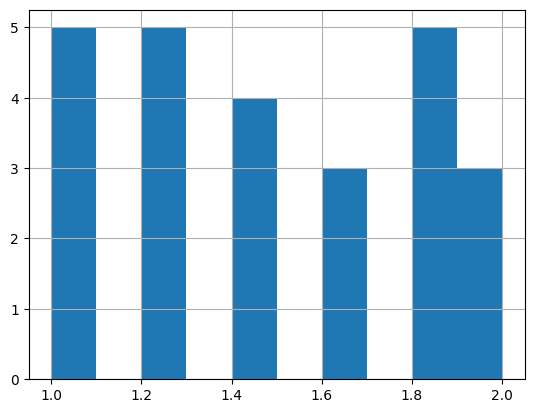

In [30]:
# take the average of scores by 5 evaulators
eval_test['score'] = eval_test.filter(regex='^T', axis = 1).mean(axis=1)
eval_test['score'].hist()

## Evaluate
code from https://competitions.codalab.org/forums/22145/4564/

In [11]:
template = pd.read_csv('submission/template.csv')
print(len(template))
print(template.head())
template['ranking'] = 1
template.head()

948
   QuestionId  ranking
0           0      NaN
1           1      NaN
2           2      NaN
3           3      NaN
4           4      NaN


,QuestionId,ranking
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [14]:
def evaluate(truth, submission):
    QL = list(truth.left)
    QR = list(truth.right)
    if len(QL) != len(QR):
        message = 'left and right lengths are not the same'
        exit(message)

    submission_preference = []
    for idx in range(len(QL)):
        rankL = submission[submission.QuestionId==QL[idx]].ranking.values[0]
        rankR = submission[submission.QuestionId==QR[idx]].ranking.values[0]
        submission_preference.append(1 if rankL<rankR else 2)
    return sum(x==y for x,y in zip(truth["preference"],submission_preference))/len(QL)

max([
    evaluate(eval_validation.rename(columns={"T1_ALR":"preference"})[["left","right","preference"]], template),
    evaluate(eval_validation.rename(columns={"T2_CL":"preference"})[["left","right","preference"]], template),
    evaluate(eval_validation.rename(columns={"T3_GF":"preference"})[["left","right","preference"]], template),
    evaluate(eval_validation.rename(columns={"T4_MQ":"preference"})[["left","right","preference"]], template),
    evaluate(eval_validation.rename(columns={"T5_NS":"preference"})[["left","right","preference"]], template)])

0.64

In [ ]:
max([
    evaluate(eval_test.rename(columns={"T1_ALR":"preference"})[["left","right","preference"]], template),
    evaluate(eval_test.rename(columns={"T2_CL":"preference"})[["left","right","preference"]], template),
    evaluate(eval_test.rename(columns={"T3_GF":"preference"})[["left","right","preference"]], template),
    evaluate(eval_test.rename(columns={"T4_MQ":"preference"})[["left","right","preference"]], template),
    evaluate(eval_test.rename(columns={"T5_NS":"preference"})[["left","right","preference"]], template)])